#  Hybrid Classical-Quantum Transfer Learning for Cardiomegaly Detection in Chest X-Rays 

## load data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random
import os
import copy
        
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, Dataset
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from nngeometry.layercollection import LayerCollection
from nngeometry.metrics import FIM
from nngeometry.object import PMatKFAC, PMatDense
%matplotlib inline

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(123)
    
from watermark import watermark
%reload_ext watermark
%watermark 
%watermark --iversions

Last updated: 2023-03-04T18:58:40.435437+08:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.8.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

matplotlib : 3.6.3
numpy      : 1.23.5
torchvision: 0.14.1
seaborn    : 0.12.2
torch      : 1.13.1
pandas     : 1.5.3



In [2]:
import time
n_qubits = 6                     # Number of qubits.
q_depth = 6                      # Depth of the quantum circuit (number of variational layers).
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights.

step = 10e-4                     # Learning rate.
weight_decay = 10e-4             # Weight_decay for learning rate.
batch_size = 8                   # Number of samples for each training step.
init_epochs = 2                  # Number of init epochs.
train_epochs = 18                # Number of training epochs.
step_size= 2                     # Learning rate changing epochs.
gamma_lr_scheduler = 0.3         # Learning rate reduction applied every step_size epochs.  

start_time = time.time()         # Start of the computation timer

In [3]:
from tqdm import tqdm 
import time
start = time.time()
img_size = 256

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)), 
        transforms.CenterCrop((224,224)),
        #transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAutocontrast(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}


data_dir = 'chexpert-corrected/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    if transforms.Normalize in data_transforms['val'].transforms:
        norm = tranform_start[trans_list.index(transforms.Normalize)]
        mean = np.array(norm.mean)#np.array([0.485, 0.456, 0.406])
        std = np.array(norm.std)#np.array([0.229, 0.224, 0.225])
        img = std * input_tensor + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

own_elapsed = time.time() - start
print("Time elapsed: ", own_elapsed)

Time elapsed:  0.008542776107788086


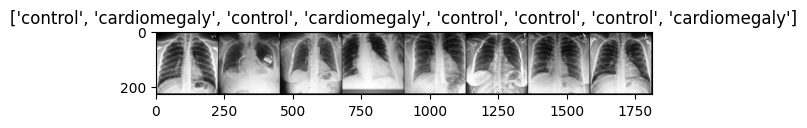

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
#resize image
import cv2
import PIL
from glob import glob

def read_img(img_path,tranform_):
    img = cv2.imread(img_path)
    transform = transforms.Compose(tranform_)
    img = transform(PIL.Image.fromarray(img))
    return img

print('Scans found:', len(image_datasets['train'].imgs)+ len(image_datasets['val'].imgs))

Scans found: 2436


### GradCam

In [6]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50,resnext50_32x4d,resnet18,densenet161,wide_resnet50_2, densenet121, densenet161,densenet201
from PIL import Image

### pre-process dataset
generate image from address

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device = 'cpu' #qiskit don't support gpu on windows

cuda:0


In [8]:
from tqdm import tqdm 
train_img = []
train_ids = []
train_y = []

img_size=256
tranform_ = [transforms.Resize((img_size, img_size)), 
             transforms.CenterCrop((224,224)),
             #transforms.RandomRotation(30),
             #transforms.RandomHorizontalFlip(p=0.5),
             #transforms.RandomAutocontrast(p=0.5),
             #transforms.ToTensor(),
             #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]

train_img = []
train_ids = []
train_y = []

for img_path in tqdm(image_datasets["train"].imgs):
    train_img.append(read_img(img_path[0],tranform_))
    train_ids.append(img_path[0].split("\\")[2])
    train_y.append(img_path[1])
    
#valid_img = []
#valid_ids = []
#valid_y = []
#
#for img_path in tqdm(image_datasets["val"].imgs):
#    valid_img.append(read_img(img_path[0],tranform_))
#    valid_ids.append(img_path[0].split("\\")[2])
#    valid_y.append(img_path[1])
    
test_img = []
test_ids = []
test_y = []
for img_path in tqdm(image_datasets["val"].imgs):
    test_img.append(read_img(img_path[0],tranform_))
    test_ids.append(img_path[0].split("\\")[2])
    test_y.append(img_path[1])

100%|███████████████████████████████████████████████████████████████████████████████| 730/730 [00:01<00:00, 671.32it/s]


In [9]:
#qamp_IMAGE_DIR = "qamp"

import time
start = time.time()

# * better way

tranform_ = [#transforms.Resize((img_size, img_size)), 
             #transforms.CenterCrop((224,224)),
             #transforms.RandomRotation(30),
             #transforms.RandomHorizontalFlip(p=0.5),
            #transforms.RandomVerticalFlip(p=0.5),
             #transforms.RandomAutocontrast(p=1.0),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
transform = transforms.Compose(tranform_)

train_imgg = []
for img in tqdm(train_img):
    img = transform(img)
    train_imgg.append(img)
##train_ds=torch.tensor(np.array(train_img), device=device).float()
train_y = torch.tensor(train_y, device=device).float()
train_ds = TensorDataset(torch.stack(train_imgg).to(device), train_y)
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
train_size = len(train_dataloader)

tranform_ = [#transforms.Resize((img_size, img_size)), 
             #transforms.CenterCrop((224,224)),
             #transforms.RandomRotation(30),
             #transforms.RandomHorizontalFlip(p=0.5),
             #transforms.RandomAutocontrast(p=1.0),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
transform = transforms.Compose(tranform_)

#valid_imgg=[]
#for img in tqdm(valid_img):
#    img = transform(img)
#    valid_imgg.append(img)
###valid_ds=torch.tensor(np.array(valid_img), device=device).float()
#valid_y = torch.tensor(valid_df['Cardiomegaly'].values, device=device).float()
#valid_ds = TensorDataset(torch.stack(valid_imgg).to(device), valid_y)
#valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=2, shuffle=True)
#valid_size = len(valid_dataloader)

test_img_ = []
for img in tqdm(test_img):
    img = transform(img)
    test_img_.append(img)
#test_ds=torch.tensor(np.array(test_img_), device=device).float()
test_y = torch.tensor(test_y, device=device).float()
test_ds = TensorDataset(torch.stack(test_img_).to(device), test_y)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)#, sampler= sampler)


own_elapsed = time.time() - start
print("Time elapsed: ", own_elapsed)

100%|███████████████████████████████████████████████████████████████████████████████| 730/730 [00:01<00:00, 721.49it/s]


Time elapsed:  4.172038316726685


## Neural Network

In [10]:
# install instruction - https://www.delftstack.com/howto/python/python-graphviz-executables-are-not-found/
#from torchviz import make_dot
#
#model = resnet18()
#batch = next(iter(train_dataloader))[0]
##x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)#8, 3, 224, 224
#yhat = model(batch) # Give dummy batch to forward().
#make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

In [11]:
from math import pi
from scipy.special import logsumexp
import numpy as np


# This class is used to calculate the effective dimension of a model (classical or quantum)
# It implicitly computed the normalised Fisher information (which is called fhat) and then computes the eff dimension


class EffectiveDimension:
    def __init__(self, model, num_thetas, num_inputs):
        """
        Computes the effective dimension for a parameterised model.
        :param model: class instance
        :param num_thetas: int, number of parameter sets to include
        :param num_inputs: int, number of input samples to include
        """
        self.model = model
        self.d = model.d
        self.num_thetas = num_thetas
        self.num_inputs = num_inputs
        # Stack data together and combine parameter sets to make calcs more efficient
        rep_range = np.tile(np.array([num_inputs]), num_thetas)
        params = np.random.uniform(self.model.thetamin, self.model.thetamax, size=(self.num_thetas, model.d))
        self.params = np.repeat(params, repeats=rep_range, axis=0)
        x = np.random.normal(0, 1, size=(self.num_inputs, self.model.inputsize))
        self.x = np.tile(x, (self.num_thetas, 1))

    def get_fhat(self):
        """
        :return: ndarray, f_hat values of size (num_inputs, d, d)
        """
        grads = self.model.get_gradient(params=self.params, x=self.x)  # get gradients, dp_theta
        output = self.model.forward(params=self.params, x=self.x)  # get model output
        fishers = self.model.get_fisher(gradients=grads, model_output=output)
        fisher_trace = np.trace(np.average(fishers, axis=0))  # compute the trace with all fishers
        # average the fishers over the num_inputs to get the empirical fishers
        fisher = np.average(np.reshape(fishers, (self.num_thetas, self.num_inputs, self.d, self.d)), axis=1)
        f_hat = self.d * fisher / fisher_trace  # calculate f_hats for all the empirical fishers
        return f_hat, fisher_trace

    def eff_dim(self, f_hat, n):
        """
        Compute the effective dimension.
        :param f_hat: ndarray
        :param n: list, used to represent number of data samples available as per the effective dimension calc
        :return: list, effective dimension for each n
        """
        effective_dim = []
        for ns in n:
            Fhat = f_hat * ns / (2 * pi * np.log(ns))
            one_plus_F = np.eye(self.d) + Fhat
            det = np.linalg.slogdet(one_plus_F)[1]  # log det because of overflow
            r = det / 2  # divide by 2 because of sqrt
            effective_dim.append(2 * (logsumexp(r) - np.log(self.num_thetas)) / np.log(ns / (2 * pi * np.log(ns))))
        return effective_dim

### Quantum layer

In [12]:
import pennylane as qml
dev = qml.device('default.qubit', wires=n_qubits)

In [13]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    #CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): #loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2): #loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [14]:
@qml.qnode(dev, interface='torch') 
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)   
        
        # Embed features in the quantum node
        RY_layer(q_in)
        
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

### training function

In [15]:
import copy
from torchsummary import summary as quick_sum # this is buggy, but light
from torchinfo import summary # this is good, but take a lot of memory
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve, accuracy_score,confusion_matrix,classification_report
save_result = True
if save_result == True:
    # create folder and save the result
    time_str = time.strftime("%Y%m%d-%H%M%S")
    result_OUT = f"image_result/(6qubit)freezer_init_{time_str}"
    os.makedirs(result_OUT, exist_ok=True)

In [16]:
def get_variable_name(variable):
    globals_dict = globals()

    return [var_name for var_name in globals_dict if globals_dict[var_name] is variable]

In [17]:
def conf_matrix(y, y_pred):
    fig, ax =plt.subplots(figsize=(3.5,3.5))
    labels=['No','Yes']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title('Cardiomegaly?', fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test')
    ax.set_xlabel('Predicted')

In [18]:
def grad_camera(models, target_layers, picture_select, transform_start=None, transform_end=None,name=None):
    """ Train function
    Args:
        models: pytroch model
        target_layers :  target layer of the model
        picture_select (str): select picture from all the image
        transform_start : input picture display
        transform_end : output picture display
    Returns:
        pytorch model
    Raises:
        None
    """
    #target_layers = target_layers
    # need modify yourself
    if transform_start == None:
        tranform_start = [transforms.Resize((img_size, img_size)), 
                        transforms.CenterCrop((224,224)),
                        #transforms.RandomRotation(30),
                        #transforms.RandomHorizontalFlip(p=0.5),
                        #transforms.RandomAutocontrast(p=0.5),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ]
        #return tranform_start
    input_tensor = torch.stack([read_img(eval(f'image_datasets["train"].imgs{picture_select}[0]'), tranform_start)])#torch.stack(train_img)[:1,:,:,:]# Create an input tensor image for your model..
    print(input_tensor.numpy()[0].shape)
    y= models(input_tensor.to(device))
    # Note: input_tensor can be a batch tensor with several images!
    
    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAMPlusPlus(model=models, target_layers=target_layers)#, use_cuda=False)
    
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor.to(device))[0, :]#, targets=targets)[0, :]
    
    # In this example grayscale_cam has only one image in the batch:
    if transform_end == None:
        trans_list = list(map(type, tranform_start))
        input_tensor = input_tensor.numpy()[0]
        input_tensor = np.transpose(input_tensor, (1,2,0))
        if transforms.Normalize in trans_list:
            #img = np.transpose(input_tensor, (1,2,0))
            # We apply the inverse of the initial normalization operation.
            norm = tranform_start[trans_list.index(transforms.Normalize)]
            mean = np.array(norm.mean)#np.array([0.485, 0.456, 0.406])
            std = np.array(norm.std)#np.array([0.229, 0.224, 0.225])
            img = std * input_tensor + mean  
            input_tensor = np.clip(img, 0, 1)
    #img= read_img(eval(f'list(all_image_paths.values()){picture_select}'), transform_end)
    #img =np.float32(img) / 255
    visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=True)
    
    
    #_, y_prob = torch.max(y, 1)
    y_probb = nn.Sigmoid()(y)[0]
    df = image_datasets["train"].imgs
    plt.title(f'Cardiomegaly?\n true:{eval(f"df{picture_select}[1]")}\n pred[no/yes]:{np.round(y_probb.cpu().detach().numpy(),3)}', fontsize=20)
    #Image.fromarray(visualization, 'RGB')
    plt.imshow(visualization)
    if (save_result == True and name != None): plt.savefig(f"{result_OUT}/{name}_visual_img.png")
    return visualization

In [19]:
def train_model(model, criterion, optimizer,scheduler, num_epochs, loss_save=None, scheduler_set = ["outside_train"], sig_out = True,transform = True, save = True):
    """ Train function
    Args:
        model : pytroch model
        criterion :  Criterion
        optimizer : optimize
        scheduler : scheduler
        num_epochs (int): Number of epochs
        loss_save (bool): select model save condition, 
            it can be 'None' for best_loss_train, 'True' for best_acc or False for best_loss (default=None)
        scheduler_set (list): The set the scheduler place, 
            it can include ('inside_train', 'outside_train', 'inside_valid', 'outside_valid', outside_loss_valid)
        sig_out (bool): training sigmoid output
        transform (bool): transform each epoch
    Returns:
        pytorch model
    Raises:
        None
    """
    #qamp_IMAGE_DIR = "qamp"
    start = time.time()
    
    #layer_collection = LayerCollection.from_model(model)
    #d = layer_collection.numel()
    #print('d= ', d)
    name = get_variable_name(model)[0]
    print('name:',name)
    
    #train_ds=torch.tensor(np.array(train_img), device=device).float()
    
    
    #own_elapsed = time.time() - start
    #print("loader Time elapsed: ", own_elapsed)
    global train_ds
    global train_dataloader
    #global valid_ds
    #global valid_dataloader
    
    train_loss = []
    train_loss_list = []
    training_loss = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0   # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    opt_rate=[]
    for epoch in range(num_epochs):
        if transform:
            trans_start = time.time()
            tranform_ = [#transforms.Resize((img_size, img_size)), 
                 #transforms.CenterCrop((224,224)),
                 #transforms.RandomRotation(30),
                 #transforms.RandomHorizontalFlip(p=.5),
                 #transforms.RandomVerticalFlip(p=.5),
                 transforms.RandAugment(),
                 #transforms.RandomAdjustSharpness(sharpness_factor=2),
                 #transforms.RandomSolarize(threshold=192.0),
                 #transforms.RandomSolarize(threshold=192.0),
                 #transforms.RandomInvert(),
                 transforms.RandomAutocontrast(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            transform = transforms.Compose(tranform_)
            
            train_imgg = []
            for img in train_img:
                img = transform(img)
                train_imgg.append(img)
            
            train_ds = TensorDataset(torch.stack(train_imgg).to(device), train_y)
            train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
            
            #valid_imgg=[]
            #for img in valid_img:
            #    img = transform(img)
            #    valid_imgg.append(img)
            #valid_ds = TensorDataset(torch.stack(valid_imgg).to(device), valid_y)
            #valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=2, shuffle=False)
            
            print("Transform Time elapsed: ", time.time() - trans_start)
        
        train_size = len(train_dataloader)
        #valid_size = len(valid_dataloader)
        
        running_loss = 0.0
        running_corrects = 0
        print(epoch+1,'Training started:')
        #for dataset_size_multiplier in range(5):
        for index, data in enumerate(tqdm(train_dataloader)):
            inputs, labels = data[0].to(device).type(torch.float), data[1].to(device).type(torch.long)
            #running_loss = 0.0
            # Set model to training mode
            model.train() 
            
            # Each epoch has a training and validation phase
            batch_size_ = len(inputs)
            optimizer.zero_grad()
            
            # Iterate over data.
            #n_batches = dataset_sizes[phase] // batch_size
            # Track/compute gradient and make an optimization step only when training
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                #nn.sigmoid(outputs)
                #print(outputs)
                if len(outputs.shape) == 1:
                    outputs = torch.stack([outputs])
                if sig_out == True:
                    outputs = nn.Sigmoid()(outputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)#torch.stack(label_list))
                loss.backward()
                optimizer.step()
                if "inside_train" in scheduler_set:
                    scheduler.step()
                
            
            # Print iteration results
            running_loss += loss.item() #*inputs.size(0)#* batch_size_
            train_loss.append(loss.item() )#*inputs.size(0))#*batch_size_)
            batch_corrects = torch.sum(preds == labels.data).item()
            running_corrects += batch_corrects
            if (index+1)%train_size == 0:
                #print(outputs)
                #print(preds)
                print('Train Epoch: {}/{} train loss {:.4f} Acc batch: {:.4f} learning_rate: {:.4f}'.format(epoch + 1, num_epochs, running_loss/train_size, running_corrects/train_ds.tensors[0].size(0),optimizer.state_dict()['param_groups'][0]['lr']))
                training_loss.append(running_loss/train_size)
        if running_corrects/len(train_ds) > best_acc_train:
            best_acc_train = running_loss
        if running_loss < best_loss_train:
            best_loss_train = running_corrects/len(train_ds)#round(new_train_df.shape[0]*split_size)
        if "outside_train" in scheduler_set:
            scheduler.step()
                
        train_loss_list.append(np.mean(train_loss))
        #opt_rate.append(optimizer.state_dict()['param_groups'][0]['lr'])
    if save_result: np.savetxt(f"{result_OUT}/{name}_training_loss.csv", training_loss)#save
    if save_result: np.savetxt(f"{result_OUT}/{name}_train_loss.csv", train_loss)#save
    if save_result: np.savetxt(f"{result_OUT}/{name}_train_loss_list.csv", train_loss_list)#save
            
    own_elapsed = time.time() - start
    print("Time elapsed: ", own_elapsed)
    
    # Print final results 
    #if loss_save != None:
    #    model.load_state_dict(best_model_wts)
    #print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
    if len(train_loss_list) > 1:
        plt.rcParams["figure.figsize"] = (5.5, 4)
        plt.title("Training loss against Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Training loss")
        plt.plot(range(0,len(train_loss_list)), train_loss_list, color="blue")
        if save_result == True: plt.savefig(f"{result_OUT}/{name}_train_loss.png")#save pic
        plt.show()
    if save:
        running_loss = 0.0
        with torch.no_grad():
            model.eval()
            
            y_pred = []
            for index, data in enumerate(tqdm(test_dataloader)):
                model.eval()
                batch_inputs, batch_labels = data[0].to(device).type(torch.float), data[1].to(device).type(torch.long)
                with torch.set_grad_enabled(False):
                    outputs = model(batch_inputs)
                    y_pred.append(outputs[0])
                    #assert isinstance(outputs.item(), float)
                    #print(outputs, batch_labels)
                    #if len(outputs.shape) == 1:
                    #    outputs = torch.stack([outputs])
                    if sig_out == True:
                        outputs = nn.Sigmoid()(outputs)
                    #_, preds = torch.max(outputs, 1)
                    loss    = criterion(outputs, batch_labels)
                #print(f"Step {index} loss: {loss}")
                running_loss += loss.item()
            _, y_pred_prob = torch.max(torch.stack(y_pred), 1)
            y_pred_prob = y_pred_prob.cpu()
            if save_result == True: np.savetxt(f"{result_OUT}/{name}_test_loss.csv", y_pred_prob)#save
            #print(y_pred, y_pred_prob)
            print(classification_report(test_y.cpu().long(), torch.tensor(y_pred_prob.detach().numpy()),digits=4))
            conf_matrix(test_y.cpu().long(), y_pred_prob)
            if save_result == True: plt.savefig(f"{result_OUT}/{name}_conf_matrix.png")#save pic
            plt.figure(figsize = (5.5, 4))
            fpr, tpr, _ =roc_curve(test_y.cpu().long(), torch.tensor(y_pred_prob.detach().numpy()))
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
            plt.plot([0, 1], [0, 1],'r--')
            plt.title('ROC curve',fontsize=25)
            plt.ylabel('True Positive Rate',fontsize=18)
            plt.xlabel('False Positive Rate',fontsize=18)
            plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
            if save_result == True: plt.savefig(f"{result_OUT}/{name}_roc.png") #save pic
            plt.show()
    return model

## init_freezer

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def n_count_parameters(model):
    return sum(p.numel() for p in model.parameters() if not(p.requires_grad))

In [21]:
def train_func(cnn_model,init_step, train_step,save_model=save_result):
    criterion = nn.CrossEntropyLoss()
    if init_step > 0:
        optimizer = torch.optim.Adam(cnn_model.parameters(), lr=step, weight_decay = weight_decay)
        #optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, cnn_model.parameters()), lr=10e-4, momentum=0.9)
        exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma_lr_scheduler)
        cnn_model = train_model(cnn_model.to(device), 
                                criterion, optimizer,exp_lr_scheduler, 
                                init_step,None,["outside_train"], False, True,False)
    
    for param in cnn_model.parameters():
        param.requires_grad = True
    
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=(step*0.3)*(np.floor(init_step/2)) if init_step > 0  else step, weight_decay = weight_decay)
    #optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, cnn_model.parameters()), lr=3e-4, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma_lr_scheduler)
    cnn_model = train_model(cnn_model.to(device), 
                            criterion, optimizer,exp_lr_scheduler, 
                            train_step,None,["outside_train"], False, True)#["outside_train"]
    
    cnn_model_visual = grad_camera(cnn_model, [cnn_model.features[-1]],[0] ,transform_start=None, transform_end=None,name=get_variable_name(cnn_model)[0])
    if save_model:
        torch.save(cnn_model.state_dict(),f"{result_OUT}/{get_variable_name(cnn_model)[0]}.pt")
    return cnn_model

In [22]:
def prob_loop(sample,models, target_layers, picture_select, transform_start=None, transform_end=None,name=None):
    # need modify yourself
    if transform_start == None:
        tranform_start = [transforms.Resize((img_size, img_size)), 
                        transforms.CenterCrop((224,224)),
                        #transforms.RandomRotation(30),
                        #transforms.RandomHorizontalFlip(p=0.5),
                        #transforms.RandomAutocontrast(p=0.5),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ]
    input_tensor = torch.stack([read_img(eval(f'image_datasets[sample].imgs{picture_select}[0]'), tranform_start)])#torch.stack(val_img)[:1,:,:,:]# Create an input tensor image for your model..
    y= models(input_tensor.to(device))
    
    y_probb = nn.Sigmoid()(y)[0]
    return y_probb


def make_df_y_probb(sample,model) :  
    df_y_probb = pd.DataFrame(columns=['image', 'p_yes', 'p_no'])
    df = image_datasets[sample].imgs
    for i in tqdm(range(len(df))):
        image_name = df[i][0][-10:]
        y_probb = prob_loop(sample, model, [model.features[-1]] \
            ,[i] ,transform_start=None, transform_end=None)
        y_probb = y_probb.cpu()
        p_yes = y_probb.detach().numpy()[0]
        p_no = y_probb.detach().numpy()[1]
        row = {'image' : image_name, 'p_yes': p_yes, 'p_no': p_no}
        new_df = pd.DataFrame([row])
        df_y_probb =  pd.concat([df_y_probb, new_df], axis = 0, ignore_index=True)
    return df_y_probb

def plot_ROC(name,y_true, y_score):

    # ROC Curve and AUROC
    plt.figure(0).clf()
    if np.sum(y_true) != 0.:        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = round(roc_auc_score(y_true, y_score), 4)
        plt.plot(fpr,tpr,label=name + ", AUC =" + str(auc))
    if save_result == True: plt.savefig(f"{result_OUT}/{name}_roc.png") #save pic
    plt.legend()
    plt.show()

def make_csv(model, sample="val",result=True):
    df = make_df_y_probb(sample,model)
    if sample == "val":
        df_list = 361*[1] + 369*[0]
    elif sample == "train":
        df_list = 850*[1] + 856*[0]
    df = df.assign(label = df_list)

    pred_list = np.array(df.p_yes) / (np.array(df.p_yes) + np.array(df.p_no))
    df = df.assign(cmg_pred = pred_list)
    #elif sample == "train":
    #    pred_val_list =( np.array(df.p_yes) / (np.array(df.p_yes) + np.array(df.p_no)) + 0.5).astype('int32')
    #    df = df.assign(pred = pred_val_list)
    
    pred_list =( np.array(df.p_yes) / (np.array(df.p_yes) + np.array(df.p_no)) + 0.5).astype('int32')
    df = df.assign(pred = pred_list)
    
    df = df.rename(columns={"cmg_pred": "prob"})
    if sample == "val":
        df.sort_values(by = 'image')[0:16]
    elif sample == "train":
        df.sort_values(by = 'image')
    if save_result: df.to_csv(f'{result_OUT}/y_probbs_{get_variable_name(model)[0]}_{sample}.csv', index = False)
    
    if result:
        name = get_variable_name(model)[0]
        df_val = pd.read_csv(f'{result_OUT}/y_probbs_{name}_{sample}.csv') 
        prediction = np.array(df_val.prob) 
        name_ROC = f"Cardiomegaly - {name}_{sample}"
        plot_ROC(name_ROC, np.array(df_val.label), prediction)
        print(classification_report(np.array(df_val.label),  (prediction+ 0.5).astype('int32')))#prediction))
    return df

### Densenet 121 Pennylane hybird

name: PL_qnn_model
Transform Time elapsed:  4.622044086456299
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:55<00:00,  1.10s/it]

Train Epoch: 1/2 train loss 0.6678 Acc batch: 0.6055 learning_rate: 0.0010


Transform Time elapsed:  6.122109413146973
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:48<00:00,  1.07s/it]

Train Epoch: 2/2 train loss 0.6040 Acc batch: 0.6882 learning_rate: 0.0010
Time elapsed:  475.08125376701355


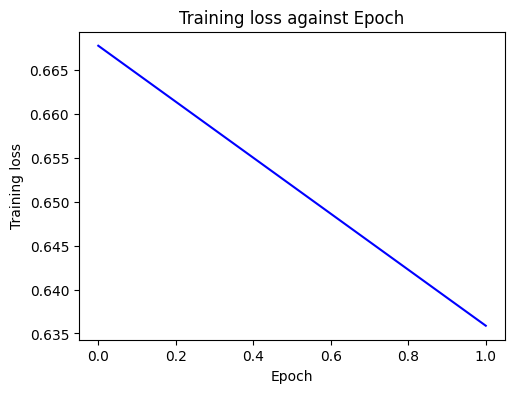

name: PL_qnn_model
Transform Time elapsed:  4.998660564422607
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:12<00:00,  1.18s/it]

Train Epoch: 1/18 train loss 0.5846 Acc batch: 0.7186 learning_rate: 0.0003


Transform Time elapsed:  4.061263084411621
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:54<00:00,  1.09s/it]

Train Epoch: 2/18 train loss 0.5268 Acc batch: 0.7691 learning_rate: 0.0003


Transform Time elapsed:  4.095659017562866
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:15<00:00,  1.19s/it]

Train Epoch: 3/18 train loss 0.4584 Acc batch: 0.8206 learning_rate: 0.0001


Transform Time elapsed:  6.903301477432251
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:27<00:00,  1.25s/it]

Train Epoch: 4/18 train loss 0.4293 Acc batch: 0.8447 learning_rate: 0.0001


Transform Time elapsed:  6.890492916107178
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:25<00:00,  1.24s/it]

Train Epoch: 5/18 train loss 0.4026 Acc batch: 0.8576 learning_rate: 0.0000


Transform Time elapsed:  5.228893041610718
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:26<00:00,  1.25s/it]

Train Epoch: 6/18 train loss 0.3826 Acc batch: 0.8746 learning_rate: 0.0000


Transform Time elapsed:  5.885075569152832
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:29<00:00,  1.26s/it]

Train Epoch: 7/18 train loss 0.3694 Acc batch: 0.8845 learning_rate: 0.0000


Transform Time elapsed:  6.806028127670288
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:26<00:00,  1.25s/it]

Train Epoch: 8/18 train loss 0.3642 Acc batch: 0.8839 learning_rate: 0.0000


Transform Time elapsed:  6.726487874984741
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:03<00:00,  1.14s/it]

Train Epoch: 9/18 train loss 0.3562 Acc batch: 0.8921 learning_rate: 0.0000


Transform Time elapsed:  4.361162900924683
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:14<00:00,  1.19s/it]

Train Epoch: 10/18 train loss 0.3527 Acc batch: 0.8939 learning_rate: 0.0000


Transform Time elapsed:  4.351877689361572
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:03<00:00,  1.14s/it]

Train Epoch: 11/18 train loss 0.3597 Acc batch: 0.8857 learning_rate: 0.0000


Transform Time elapsed:  3.387086868286133
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:58<00:00,  1.12s/it]

Train Epoch: 12/18 train loss 0.3501 Acc batch: 0.8980 learning_rate: 0.0000


Transform Time elapsed:  3.7388150691986084
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:08<00:00,  1.16s/it]

Train Epoch: 13/18 train loss 0.3496 Acc batch: 0.8974 learning_rate: 0.0000


Transform Time elapsed:  3.7876720428466797
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [04:03<00:00,  1.14s/it]

Train Epoch: 14/18 train loss 0.3455 Acc batch: 0.9009 learning_rate: 0.0000


Transform Time elapsed:  4.247624635696411
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:55<00:00,  1.10s/it]

Train Epoch: 15/18 train loss 0.3555 Acc batch: 0.8910 learning_rate: 0.0000


Transform Time elapsed:  4.226835012435913
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:55<00:00,  1.10s/it]

Train Epoch: 16/18 train loss 0.3505 Acc batch: 0.8951 learning_rate: 0.0000


Transform Time elapsed:  3.9500463008880615
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:55<00:00,  1.10s/it]

Train Epoch: 17/18 train loss 0.3429 Acc batch: 0.9027 learning_rate: 0.0000


Transform Time elapsed:  3.748929023742676
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:55<00:00,  1.10s/it]

Train Epoch: 18/18 train loss 0.3549 Acc batch: 0.8939 learning_rate: 0.0000
Time elapsed:  4579.089752197266


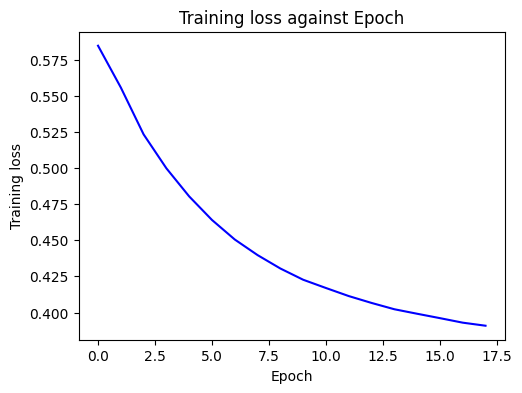

100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:36<00:00,  7.59it/s]


              precision    recall  f1-score   support

           0     0.8949    0.8255    0.8588       361
           1     0.8413    0.9051    0.8721       369

    accuracy                         0.8658       730
   macro avg     0.8681    0.8653    0.8654       730
weighted avg     0.8678    0.8658    0.8655       730



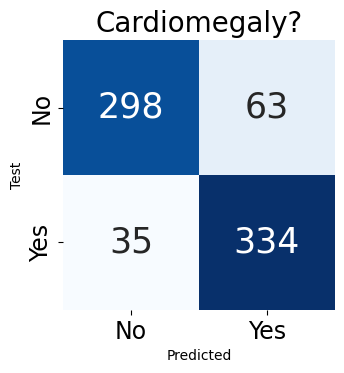

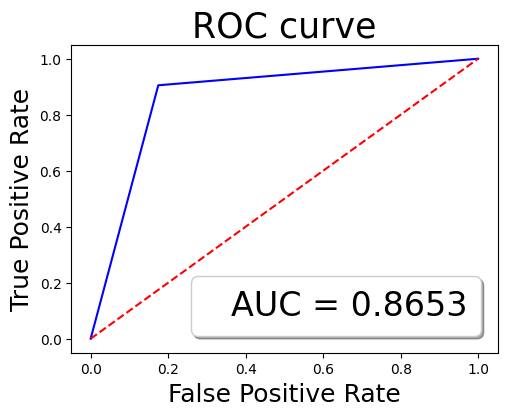

(3, 224, 224)


100%|██████████████████████████████████████████████████████████████████████████████| 1706/1706 [03:53<00:00,  7.29it/s]


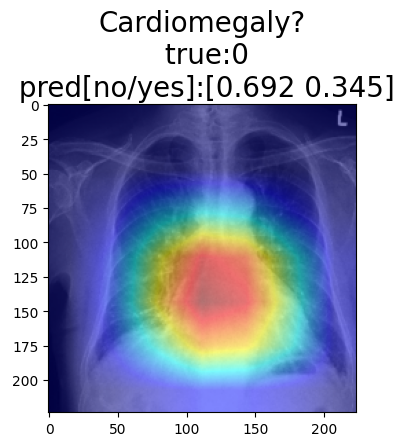

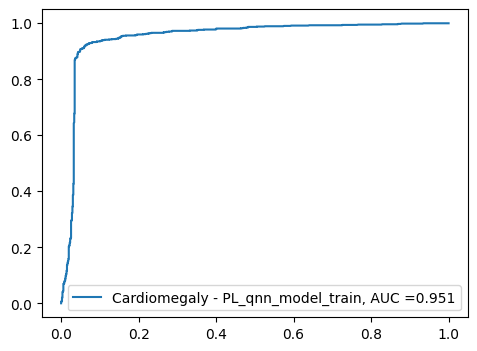

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       856
           1       0.94      0.91      0.93       850

    accuracy                           0.93      1706
   macro avg       0.93      0.93      0.93      1706
weighted avg       0.93      0.93      0.93      1706



100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:40<00:00,  7.23it/s]


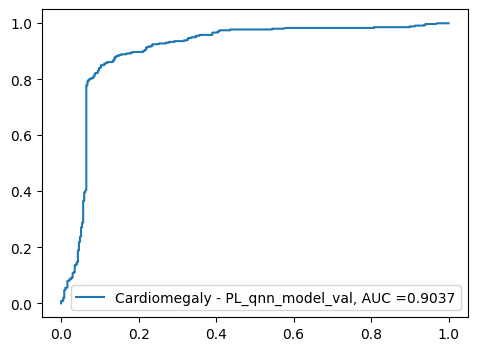

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       369
           1       0.89      0.83      0.86       361

    accuracy                           0.87       730
   macro avg       0.87      0.87      0.87       730
weighted avg       0.87      0.87      0.87       730



In [23]:
class Quantumnet(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.pre_net = nn.Linear(input_size, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        pre_out = self.pre_net(input_features) 
        q_in = torch.tanh(pre_out) * np.pi / 2.0   
        
        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        return self.post_net(q_out)

PL_qnn_model = torchvision.models.densenet121(weights= 'DEFAULT')
for param in PL_qnn_model.parameters():
    param.requires_grad = False
PL_qnn_model.classifier = Quantumnet(PL_qnn_model.classifier.in_features)
PL_qnn_model= train_func(PL_qnn_model, init_epochs, train_epochs)

'''
# Downgrade cuda driver if you meet this error:
nvrtc: error: failed to open nvrtc-builtins64_117.dll.
  Make sure that nvrtc-builtins64_117.dll is installed correctly.
'''

'''
# Some weird error
File ~\anaconda3\envs\qamp2022_gpu\lib\site-packages\torch\autograd\__init__.py:197, in backward(tensors, grad_tensors, retain_graph, create_graph, grad_variables, inputs)
    192     retain_graph = create_graph
    194 # The reason we repeat same the comment below is that
    195 # some Python versions print out the first line of a multi-line function
    196 # calls in the traceback and some print out the last line
--> 197 Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    198     tensors, grad_tensors_, retain_graph, create_graph, inputs,
    199     allow_unreachable=True, accumulate_grad=True)

RuntimeError: Function SliceBackward0 returned an invalid gradient at index 0 - got [2, 2, 2, 2, 2, 2, 2, 2, 2] but expected shape compatible with [74766790688770, 13194139533314, 269380348805122, 84662395338754, 87960930222082, 91259465105410, 98956046499842, 136339441844226, 155031139516418]
'''

for i in ['train','val']:
    exec(f"PL_qnn_model_{i}=make_csv(PL_qnn_model,'{i}')")